In [1]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from plotnine import (element_blank, scale_color_manual, scale_x_continuous, ggplot, aes, geom_line ,geom_bar, geom_point, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)

In [2]:
# defin path and load train and test data 
final_data_path = 'final data/'
output = 'model/5.Stacking/'
path_xgb = 'model/2.xgboost/'
stacking_layer1 = 'model/5.Stacking/stacking layer1 output/'
tr = pd.read_csv(final_data_path + 'train_data_final.csv', index_col = 0)
te = pd.read_csv(final_data_path + 'test_data_final.csv', index_col = 0)
gc.collect()

0

In [3]:
# train_x, train_y 
x = tr.drop(['Id', 'Response'], axis = 1)
y = tr['Response']
print(x.shape)
print(y.shape)

(1183747, 55)
(1183747,)


In [4]:
# Run at first time
tr_layer1 = tr.reset_index(drop = True).reset_index(drop = False)
te_layer1 = te.copy()

In [5]:
# Run at not first time
# tr_layer1 = pd.read_csv(stacking_layer1 + 'train_layer1.csv')
# te_layer1 = pd.read_csv(stacking_layer1 + 'test_layer1.csv')

In [6]:
best_params_xgb = pd.read_csv(path_xgb  + 'best_parameters.csv', index_col = 0).to_dict()
best_params_xgb['parameters']

{'colsample_bytree': 0.8,
 'eta': 10.039374456215448,
 'gamma': 1.0,
 'max_depth': 12.0,
 'min_child_weight': 3.0,
 'n_tree': 70.0,
 'subsample': 0.8500000000000001}

# Layer 1 _ xgboost - 1

In [7]:
layer_name = 'xgb_depth_low_tree_low'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 4
params['n_tree'] = 20
params['x'] = x
params['y'] = y
params['te'] = te

In [8]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
pd.DataFrame(scores)

[00:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.16192	eval-error:-0.16368
[2]	train-error:-0.32160	eval-error:-0.31134
[3]	train-error:-0.35349	eval-error:-0.34007
[4]	train-error:-0.36122	eval-error:-0.34906
[5]	train-error:-0.37689	eval-error:-0.37007
[6]	train-error:-0.37847	eval-error:-0.37083
[7]	train-error:-0.37589	eval-error:-0.37083
[8]	train-error:-0.37529	eval-error:-0.36931
[9]	train-error:-0.37633	eval-error:-0.36968
[10]	train-error:-0.37637	eval-error:-0.36968
[11]	train-error:-0.37475	eval-error:-0.36579
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.382948,0.421057,0.588559,0.292391,0.341667
1,2,0.392021,0.433799,0.593994,0.306328,0.383333
2,3,0.381998,0.405395,0.582124,0.277641,0.508333
3,4,0.396883,0.424507,0.590044,0.299156,0.466667
4,5,0.371869,0.400733,0.580233,0.270999,0.466667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


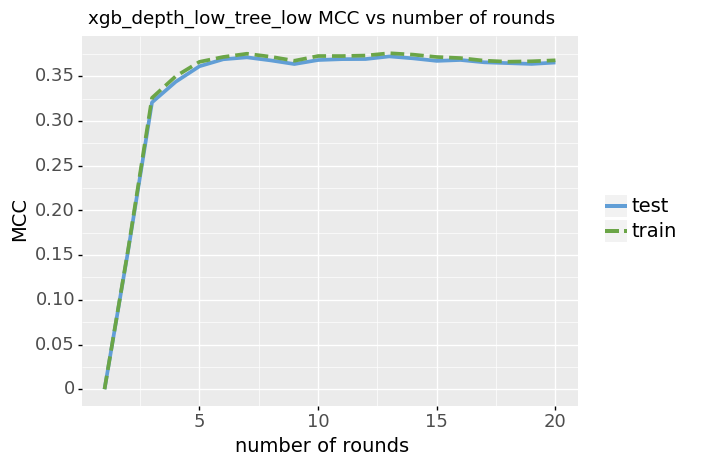

<ggplot: (-9223371922265730460)>

In [9]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
# ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [10]:
# Score: 0.39219
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)

In [11]:
def submit_and_layer_merge(csv_name, te_stacking, tr_stacking, te, scores, tr_layer, te_layer, output):
    te_stacking = pd.concat(
        [te['Id'], pd.DataFrame({'Response': te_stacking})], axis=1)
    tr_stacking = tr_stacking.sort_values('index')
    # submission = pd.DataFrame(
    #     {'Id': te['Id'], 'Response': te_stacking['Response'] > np.mean(scores['threshold'])})
    # submission['Response'] = submission['Response'].astype('int')
    # submission.to_csv(output + csv_name + '_submission.csv', index=0)

    tr_layer = pd.merge(tr_layer, tr_stacking, how='left', on='index')
    te_layer = pd.merge(te_layer, te_stacking.rename(
        columns={"Response": csv_name}), how='left', on='Id')

    return tr_layer, te_layer

In [12]:
tr_layer1_, te_layer1_ = submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)

# Layer 1 _ xgboost - 2

In [13]:
layer_name = 'xgb_depth_low_tree_medium'
params_xgb_medth_low_tree_medium = best_params_xgb['parameters']
params_xgb_medth_low_tree_medium['var_name'] = layer_name
params_xgb_medth_low_tree_medium['max_depth'] = 4
params_xgb_medth_low_tree_medium['n_tree'] = 45
params_xgb_medth_low_tree_medium['x'] = x
params_xgb_medth_low_tree_medium['y'] = y
params_xgb_medth_low_tree_medium['te'] = te

In [14]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params_xgb_medth_low_tree_medium)
pd.DataFrame(scores)

[00:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.16192	eval-error:-0.16368
[2]	train-error:-0.32160	eval-error:-0.31134
[3]	train-error:-0.35349	eval-error:-0.34007
[4]	train-error:-0.36122	eval-error:-0.34906
[5]	train-error:-0.37689	eval-error:-0.37007
[6]	train-error:-0.37847	eval-error:-0.37083
[7]	train-error:-0.37589	eval-error:-0.37083
[8]	train-error:-0.37529	eval-error:-0.36931
[9]	train-error:-0.37633	eval-error:-0.36968
[10]	train-error:-0.37637	eval-error:-0.36968
[11]	train-error:-0.37475	eval-error:-0.36579
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.387931,0.424496,0.590016,0.296828,0.300000
1,2,0.396471,0.431290,0.592928,0.305307,0.383333
2,3,0.389987,0.406298,0.582507,0.280247,0.466667
3,4,0.401621,0.432976,0.593665,0.308244,0.341667
4,5,0.375545,0.423623,0.589615,0.292654,0.300000


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922261512080.svg


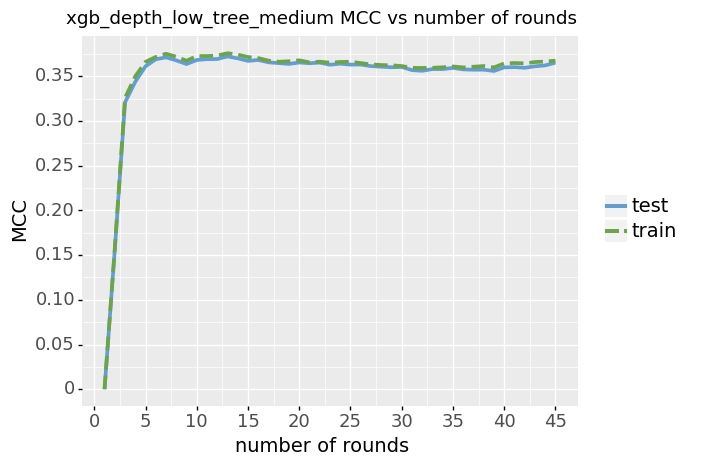

<ggplot: (-9223371922261512080)>

In [15]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [16]:
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)

# Layer 1 _ xgboost - 3

In [17]:
layer_name = 'xgb_depth_low_tree_high'
params_xgb_medth_low_tree_high = best_params_xgb['parameters']
params_xgb_medth_low_tree_high['var_name'] = layer_name
params_xgb_medth_low_tree_high['max_depth'] = 4
params_xgb_medth_low_tree_high['n_tree'] = 70
params_xgb_medth_low_tree_high['x'] = x
params_xgb_medth_low_tree_high['y'] = y
params_xgb_medth_low_tree_high['te'] = te

In [18]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params_xgb_medth_low_tree_high)
pd.DataFrame(scores)

[00:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.16192	eval-error:-0.16368
[2]	train-error:-0.32160	eval-error:-0.31134
[3]	train-error:-0.35349	eval-error:-0.34007
[4]	train-error:-0.36122	eval-error:-0.34906
[5]	train-error:-0.37689	eval-error:-0.37007
[6]	train-error:-0.37847	eval-error:-0.37083
[7]	train-error:-0.37589	eval-error:-0.37083
[8]	train-error:-0.37529	eval-error:-0.36931
[9]	train-error:-0.37633	eval-error:-0.36968
[10]	train-error:-0.37637	eval-error:-0.36968
[11]	train-error:-0.37475	eval-error:-0.36579
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.396369,0.439620,0.596532,0.312757,0.300000
1,2,0.410516,0.447005,0.599823,0.323529,0.383333
2,3,0.394360,0.408976,0.583602,0.283775,0.466667
3,4,0.409914,0.432148,0.593329,0.309639,0.466667
4,5,0.380920,0.404350,0.581701,0.276413,0.466667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262696688.svg


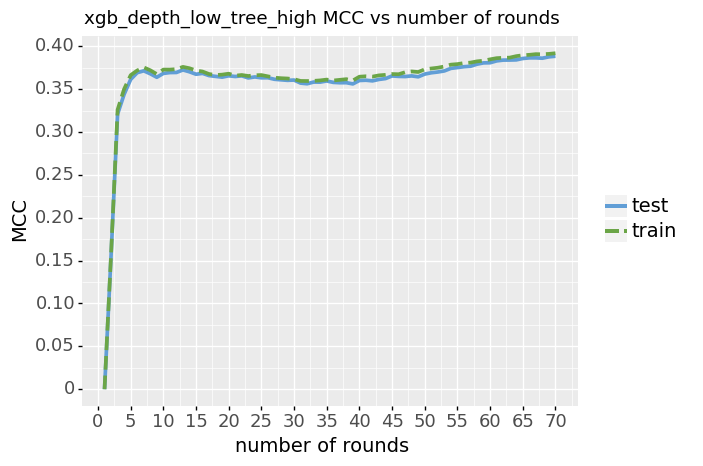

<ggplot: (-9223371922262696688)>

In [19]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 75, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [20]:
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)

# Layer 1 _ xgboost - 4

In [21]:
layer_name = 'xgb_depth_medium_tree_low'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 8
params['n_tree'] = 20
params['x'] = x
params['y'] = y
params['te'] = te

In [22]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[00:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.33045	eval-error:-0.32524
[2]	train-error:-0.37022	eval-error:-0.35454
[3]	train-error:-0.37151	eval-error:-0.35058
[4]	train-error:-0.38350	eval-error:-0.36467
[5]	train-error:-0.39383	eval-error:-0.37370
[6]	train-error:-0.39488	eval-error:-0.37562
[7]	train-error:-0.39609	eval-error:-0.37492
[8]	train-error:-0.39479	eval-error:-0.37492
[9]	train-error:-0.39780	eval-error:-0.37712
[10]	train-error:-0.39898	eval-error:-0.37727
[11]	train-error:-0.40046	eval-error:-0.37779
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.413364,0.479868,0.614962,0.352222,0.300000
1,2,0.424404,0.489610,0.619688,0.364238,0.300000
2,3,0.404464,0.452803,0.602399,0.326767,0.341667
3,4,0.421811,0.460609,0.605990,0.339141,0.383333
4,5,0.396807,0.444543,0.598695,0.317201,0.341667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262724816.svg


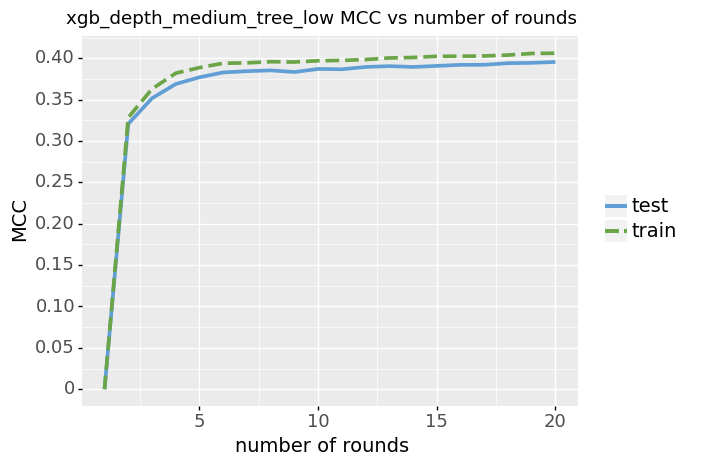

<ggplot: (-9223371922262724816)>

In [23]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 75, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Layer 1 _ xgboost - 5

In [24]:
layer_name = 'xgb_depth_medium_tree_medium'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 8
params['n_tree'] = 45
params['x'] = x
params['y'] = y
params['te'] = te

In [25]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[01:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.33045	eval-error:-0.32524
[2]	train-error:-0.37022	eval-error:-0.35454
[3]	train-error:-0.37151	eval-error:-0.35058
[4]	train-error:-0.38350	eval-error:-0.36467
[5]	train-error:-0.39383	eval-error:-0.37370
[6]	train-error:-0.39488	eval-error:-0.37562
[7]	train-error:-0.39609	eval-error:-0.37492
[8]	train-error:-0.39479	eval-error:-0.37492
[9]	train-error:-0.39780	eval-error:-0.37712
[10]	train-error:-0.39898	eval-error:-0.37727
[11]	train-error:-0.40046	eval-error:-0.37779
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.441130,0.509946,0.629839,0.386818,0.300000
1,2,0.449034,0.519815,0.634913,0.397648,0.300000
2,3,0.437699,0.492031,0.620910,0.371445,0.341667
3,4,0.467859,0.532936,0.641838,0.415957,0.300000
4,5,0.420752,0.459030,0.605265,0.337405,0.383333


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262710992.svg


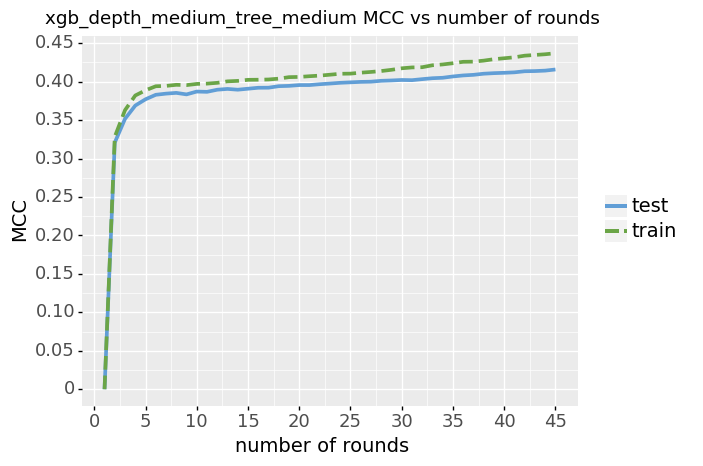

<ggplot: (-9223371922262710992)>

In [26]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Layer 1 _ xgboost - 6

In [27]:
layer_name = 'xgb_depth_medium_tree_high'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 8
params['n_tree'] = 70
params['x'] = x
params['y'] = y
params['te'] = te

In [28]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[01:18:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.33045	eval-error:-0.32524
[2]	train-error:-0.37022	eval-error:-0.35454
[3]	train-error:-0.37151	eval-error:-0.35058
[4]	train-error:-0.38350	eval-error:-0.36467
[5]	train-error:-0.39383	eval-error:-0.37370
[6]	train-error:-0.39488	eval-error:-0.37562
[7]	train-error:-0.39609	eval-error:-0.37492
[8]	train-error:-0.39479	eval-error:-0.37492
[9]	train-error:-0.39780	eval-error:-0.37712
[10]	train-error:-0.39898	eval-error:-0.37727
[11]	train-error:-0.40046	eval-error:-0.37779
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.446531,0.488912,0.619416,0.372172,0.383333
1,2,0.450839,0.533571,0.642117,0.408121,0.300000
2,3,0.443960,0.487599,0.618771,0.370119,0.383333
3,4,0.478043,0.547047,0.649446,0.430962,0.300000
4,5,0.433043,0.489627,0.619724,0.367688,0.341667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262740684.svg


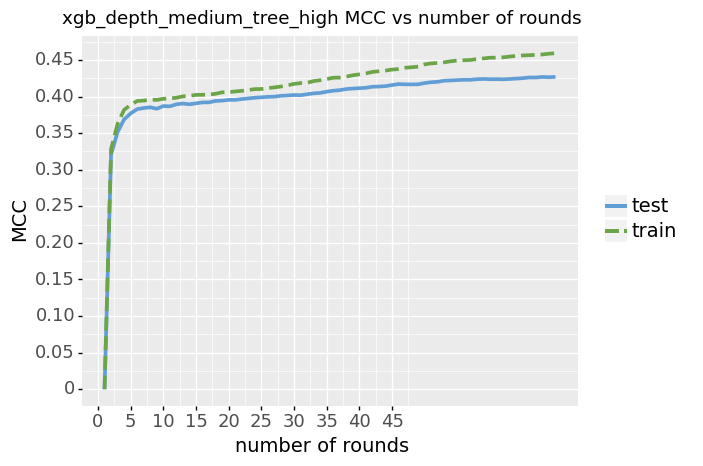

<ggplot: (-9223371922262740684)>

In [29]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Layer 1 _ xgboost - 7

In [30]:
layer_name = 'xgb_depth_high_tree_low'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 12
params['n_tree'] = 20
params['x'] = x
params['y'] = y
params['te'] = te

In [31]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[01:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.35296	eval-error:-0.34492
[2]	train-error:-0.37968	eval-error:-0.35442
[3]	train-error:-0.40352	eval-error:-0.35876
[4]	train-error:-0.40470	eval-error:-0.36898
[5]	train-error:-0.41728	eval-error:-0.38732
[6]	train-error:-0.41337	eval-error:-0.38439
[7]	train-error:-0.41974	eval-error:-0.38402
[8]	train-error:-0.41888	eval-error:-0.38480
[9]	train-error:-0.42261	eval-error:-0.39142
[10]	train-error:-0.42640	eval-error:-0.39050
[11]	train-error:-0.43147	eval-error:-0.38988
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.437304,0.504222,0.626942,0.380849,0.341667
1,2,0.451279,0.523985,0.637083,0.401700,0.341667
2,3,0.440110,0.482355,0.616232,0.364257,0.425000
3,4,0.462568,0.525392,0.637854,0.407944,0.341667
4,5,0.427755,0.486647,0.618262,0.363231,0.341667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262706340.svg


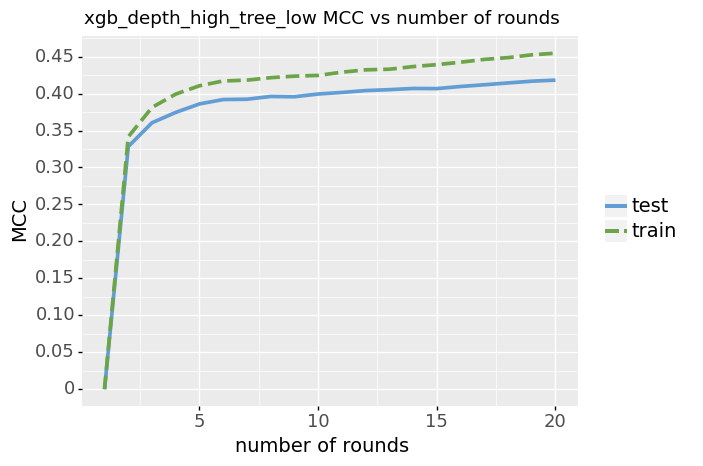

<ggplot: (-9223371922262706340)>

In [32]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Layer 1 _ xgboost - 8

In [33]:
layer_name = 'xgb_depth_high_tree_medium'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 12
params['n_tree'] = 45
params['x'] = x
params['y'] = y
params['te'] = te

In [34]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[01:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.35296	eval-error:-0.34492
[2]	train-error:-0.37968	eval-error:-0.35442
[3]	train-error:-0.40352	eval-error:-0.35876
[4]	train-error:-0.40470	eval-error:-0.36898
[5]	train-error:-0.41728	eval-error:-0.38732
[6]	train-error:-0.41337	eval-error:-0.38439
[7]	train-error:-0.41974	eval-error:-0.38402
[8]	train-error:-0.41888	eval-error:-0.38480
[9]	train-error:-0.42261	eval-error:-0.39142
[10]	train-error:-0.42640	eval-error:-0.39050
[11]	train-error:-0.43147	eval-error:-0.38988
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.440907,0.481428,0.615790,0.363740,0.425000
1,2,0.453638,0.509263,0.629533,0.391662,0.383333
2,3,0.447645,0.488349,0.619145,0.372093,0.425000
3,4,0.474428,0.523346,0.636823,0.411572,0.383333
4,5,0.433920,0.493316,0.621528,0.370986,0.341667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262738952.svg


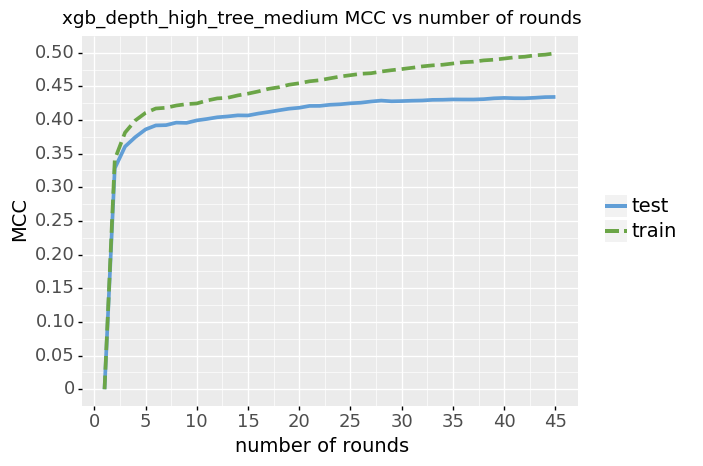

<ggplot: (-9223371922262738952)>

In [35]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 50, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Layer 1 _ xgboost - 9

In [36]:
layer_name = 'xgb_depth_high_tree_high'
params = best_params_xgb['parameters']
params['var_name'] = layer_name
params['max_depth'] = 12
params['n_tree'] = 70
params['x'] = x
params['y'] = y
params['te'] = te

In [37]:
model, scores, loss_data, tr_stacking, te_stacking = u.xgb_model(params)
tr_layer1, te_layer1 = u.submit_and_layer_merge(output = output, csv_name = layer_name, te_stacking = te_stacking, tr_stacking = tr_stacking, te = te, scores = scores, tr_layer = tr_layer1, te_layer = te_layer1)
pd.DataFrame(scores)

[02:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "ntree", "var_name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-error:-0.00000	eval-error:-0.00000
[1]	train-error:-0.35296	eval-error:-0.34492
[2]	train-error:-0.37968	eval-error:-0.35442
[3]	train-error:-0.40352	eval-error:-0.35876
[4]	train-error:-0.40470	eval-error:-0.36898
[5]	train-error:-0.41728	eval-error:-0.38732
[6]	train-error:-0.41337	eval-error:-0.38439
[7]	train-error:-0.41974	eval-error:-0.38402
[8]	train-error:-0.41888	eval-error:-0.38480
[9]	train-error:-0.42261	eval-error:-0.39142
[10]	train-error:-0.42640	eval-error:-0.39050
[11]	train-error:-0.43147	eval-error:-0.38988
[12]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.447907,0.482944,0.616536,0.367487,0.466667
1,2,0.451306,0.539645,0.645355,0.412339,0.300000
2,3,0.445874,0.492047,0.620942,0.374578,0.425000
3,4,0.472953,0.526793,0.638619,0.413644,0.383333
4,5,0.429760,0.497695,0.623670,0.372678,0.341667


c:\Users\Ali.Wu\OneDrive - shl-group.com\Desktop\Bosch line performance\utils.py:439: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371922262614892.svg


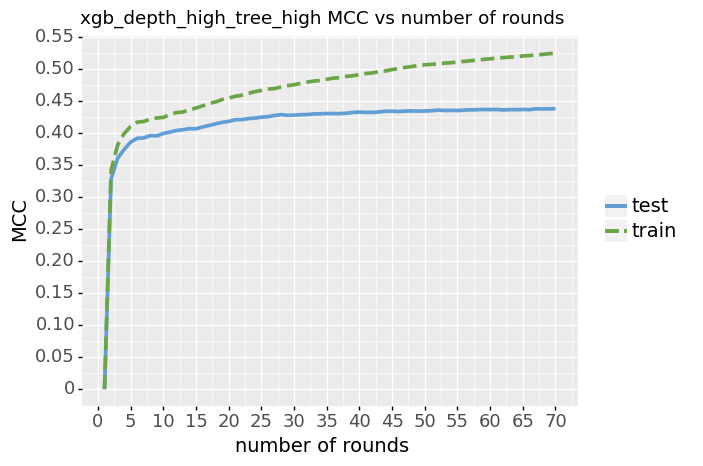

<ggplot: (-9223371922262614892)>

In [38]:
g = u.loss(loss_ = loss_data, plot_title = layer_name + ' MCC vs number of rounds',start =0, end = 75, gap = 5)
ggsave(file= layer_name + " MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Output

In [39]:
tr_layer1.to_csv(stacking_layer1 + 'train_layer1.csv', index = 0)
te_layer1.to_csv(stacking_layer1 + 'test_layer1.csv', index = 0)

In [40]:
tr_layer1.head()

,index,Id,L1_S24_F1523,L1_S24_F1525,L1_S24_F1582,L1_S24_F1585,L2_S26_F3038,L2_S26_F3099,L3_S32_F3851,L3_S32_F3854,...,Response,xgb_depth_low_tree_low,xgb_depth_low_tree_medium,xgb_depth_low_tree_high,xgb_depth_medium_tree_low,xgb_depth_medium_tree_medium,xgb_depth_medium_tree_high,xgb_depth_high_tree_low,xgb_depth_high_tree_medium,xgb_depth_high_tree_high
0,0,4,0,0,0,0,0,0,0,0,...,0,0.067201,0.006684,0.002064,0.067094,0.005995,0.001552,0.067097,0.006533,0.001162
1,1,6,0,0,0,0,0,0,0,0,...,0,0.067090,0.006513,0.001740,0.067026,0.006619,0.003662,0.067030,0.006765,0.002759
2,2,7,0,0,0,0,0,0,0,0,...,0,0.067090,0.006336,0.001972,0.066965,0.007260,0.003800,0.066967,0.008755,0.002348
3,3,9,0,0,0,0,0,0,0,0,...,0,0.066982,0.006171,0.001063,0.066955,0.005984,0.000796,0.066982,0.005985,0.000723
4,4,11,0,0,0,0,0,0,0,0,...,0,0.107426,0.034227,0.026340,0.093010,0.041358,0.039418,0.100139,0.028806,0.024032


In [41]:
te_layer1.head()

,Id,L1_S24_F1523,L1_S24_F1525,L1_S24_F1582,L1_S24_F1585,L2_S26_F3038,L2_S26_F3099,L3_S32_F3851,L3_S32_F3854,L3_S35_F3902,...,All_min_dateId_pre_label7,xgb_depth_low_tree_low,xgb_depth_low_tree_medium,xgb_depth_low_tree_high,xgb_depth_medium_tree_low,xgb_depth_medium_tree_medium,xgb_depth_medium_tree_high,xgb_depth_high_tree_low,xgb_depth_high_tree_medium,xgb_depth_high_tree_high
0,1,1,3,0,0,0,0,0,0,0,...,0.0,0.067344,0.007410,0.002694,0.067417,0.007327,0.002224,0.067422,0.007828,0.002920
1,2,0,0,0,0,0,0,0,0,0,...,0.0,0.067028,0.006239,0.001313,0.066982,0.006125,0.000945,0.066992,0.006170,0.001005
2,3,1,2,0,0,1,2,0,0,0,...,0.0,0.067344,0.007345,0.002801,0.067434,0.007465,0.002570,0.067441,0.008135,0.003432
3,5,0,0,0,0,1,1,0,0,0,...,0.0,0.067248,0.006767,0.002106,0.067197,0.007262,0.001854,0.067190,0.008850,0.002380
4,8,1,2,0,0,1,2,0,0,0,...,0.0,0.067344,0.007392,0.002649,0.067417,0.007224,0.002487,0.067422,0.008285,0.003216
